### EDA for both dataset

In [ ]:
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10, MNIST
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Setting up transformations and loading a small subset of the datasets
transform = transforms.Compose([transforms.ToTensor()])

# Load a small subset of CIFAR-10 and MNIST for visualization
cifar10_data = CIFAR10(root='./data', train=True, download=True, transform=transform)
mnist_data = MNIST(root='./data', train=True, download=True, transform=transform)

# Sample a small portion of the datasets to ensure the process does not overwhelm the environment
cifar10_sample = torch.utils.data.Subset(cifar10_data, indices=range(100))
mnist_sample = torch.utils.data.Subset(mnist_data, indices=range(100))

# Function to plot class distribution
def plot_class_distribution(dataset, title):
    labels = [label for _, label in dataset]
    label_counts = {label: labels.count(label) for label in set(labels)}
    plt.bar(label_counts.keys(), label_counts.values())
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.title(f'Class Distribution in {title} Dataset')
    plt.grid(True)
    plt.show()

# Function to plot sample images
def plot_sample_images(dataset, title, n=10):
    fig, axes = plt.subplots(1, n, figsize=(15, 3))
    for i in range(n):
        ax = axes[i]
        image, label = dataset[i]
        # Permute the dimensions to move the color channels to the last dimension
        image = image.permute(1, 2, 0)
        ax.imshow(image, cmap='gray' if image.shape[-1] == 1 else None)  # Use the last dimension for channel check
        ax.axis('off')
        ax.set_title(f'Label: {label}')
    plt.suptitle(f'Sample Images from {title} Dataset')
    plt.show()
# Plotting for both datasets
plot_class_distribution(cifar10_sample, 'CIFAR-10')
plot_sample_images(cifar10_sample, 'CIFAR-10')
plot_class_distribution(mnist_sample, 'MNIST')
plot_sample_images(mnist_sample, 'MNIST')


# **Vision Transformer with MNIST Dataset**
After lot of reseach I'm starting with first model which is very basic and with small dataset to understand the conecept and actual process how works.

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()

        self.d_model = d_model  # Dimensionality of Model
        self.img_size = img_size  # Image Size
        self.patch_size = patch_size  # Patch Size
        self.n_channels = n_channels  # Number of Channels

        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2)  # (B, d_model, P_col, P_row) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, d_model, P) -> (B, P, d_model)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe

        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        # Obtaining Queries, Keys, and Values
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Dot Product of Queries and Keys
        attention = Q @ K.transpose(-2, -1)

        # Scaling
        attention = attention / (self.head_size ** 0.5)

        attention = torch.softmax(attention, dim=-1)

        attention = attention @ V

        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Concatenate outputs from each head
        attention_outputs = [head(x) for head in self.heads]
        x = torch.cat(attention_outputs, dim=-1)
        return self.linear(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.n_channels = n_channels  # Number of channels
        self.n_heads = n_heads  # Number of attention heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP
        self.classifier = nn.Linear(self.d_model, self.n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # Use the class token for classification
        return x

# Hyperparameters
d_model = 128  # Increased for better representation
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 5
alpha = 0.005

# Data Transformations
transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

# Load MNIST Dataset
train_set = MNIST(
    root="./../datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Initialize Model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Optimizer and Loss Function
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}')

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = transformer(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'\nModel Accuracy: {100 * correct / total:.2f} %')

Using device:  cuda (Tesla T4)
Epoch 1/5 loss: 0.476
Epoch 2/5 loss: 0.283
Epoch 3/5 loss: 0.215
Epoch 4/5 loss: 0.185
Epoch 5/5 loss: 0.165

Model Accuracy: 94.65 %


## With improvement, precision, f1, recall and  visualization

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Defining the PatchEmbedding class
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.linear_project = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2).transpose(1, 2)  # Flatten patches and swap axes for token sequence
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()

        self.d_model = d_model  # Dimensionality of Model
        self.img_size = img_size  # Image Size
        self.patch_size = patch_size  # Patch Size
        self.n_channels = n_channels  # Number of Channels

        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2)  # (B, d_model, P_col, P_row) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, d_model, P) -> (B, P, d_model)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe

        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        # Obtaining Queries, Keys, and Values
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Dot Product of Queries and Keys
        attention = Q @ K.transpose(-2, -1)

        # Scaling
        attention = attention / (self.head_size ** 0.5)

        attention = torch.softmax(attention, dim=-1)

        attention = attention @ V

        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Concatenate outputs from each head
        attention_outputs = [head(x) for head in self.heads]
        x = torch.cat(attention_outputs, dim=-1)
        return self.linear(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out

# Vision Transformer Class
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.n_channels = n_channels  # Number of channels
        self.n_heads = n_heads  # Number of attention heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP
        self.classifier = nn.Linear(self.d_model, self.n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # Use the class token for classification
        return x

# Data loading with error handling for dataset paths and transformations
def load_data(img_size, batch_size):
    transform = T.Compose([
        T.Resize(img_size),
        T.ToTensor(),
        T.Normalize((0.5,), (0.5,))  # Normalize for grayscale
    ])
    train_set = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
    test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)
    return train_loader, test_loader

# Setting hyperparameters and initializing the model
d_model = 128
n_classes = 10
img_size = (28, 28)
patch_size = (7, 7)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 5
alpha = 0.005
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load datasets
train_loader, test_loader = load_data(img_size, batch_size)

# Initialize the model and transfer it to the appropriate device
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

# Function to perform training and return metrics
def train_and_evaluate(model, train_loader, test_loader, epochs, device):
    metrics = []
    for epoch in range(epochs):
        model.train()
        training_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        acc = accuracy_score(all_labels, all_preds)
        prec = precision_score(all_labels, all_preds, average='macro')
        rec = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')
        metrics.append((acc, prec, rec, f1))
        print(f'Epoch {epoch+1}/{epochs}, Loss: {training_loss/len(train_loader):.3f}, Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1 Score: {f1:.3f}')
    return metrics

# Training the model and collecting metrics
metrics = train_and_evaluate(transformer, train_loader, test_loader, epochs, device)




In [ ]:
# Plotting the metrics
epochs = range(1, len(metrics)+1)
accuracy, precision, recall, f1 = zip(*metrics)
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1, label='F1 Score')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.title('Training Metrics Over Epochs')
plt.legend()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import torch

def display_sample_images(model, data_loader, device, num_images=10):
    model.eval()
    images, labels = next(iter(data_loader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

    images = images.cpu()
    predicted = predicted.cpu()
    labels = labels.cpu()

    plt.figure(figsize=(12, 4))
    for i in range(num_images):
        ax = plt.subplot(2, num_images // 2, i + 1)
        plt.imshow(images[i].reshape(28, 28), cmap='gray')
        plt.title(f'Pred: {predicted[i]}, True: {labels[i]}')
        plt.axis('off')
    plt.show()

# Call the function with the model, test_loader, and device
display_sample_images(transformer, test_loader, device)


### basline model without attention on MNIST Dataset

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import numpy as np

# Define the CNN architecture
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(7*7*64, 128)
        self.fc2 = nn.Linear(128, 10)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# Data preparation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Initialize the model, optimizer, and loss function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Metrics storage
metrics = {
    'accuracy': [],
    'precision': [],
    'recall': [],
    'f1_score': []
}

# Training the model with evaluation
def train_and_evaluate(epochs):
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluation after each epoch
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Calculate metrics
        accuracy = accuracy_score(all_labels, all_preds)
        precision = precision_score(all_labels, all_preds, average='macro')
        recall = recall_score(all_labels, all_preds, average='macro')
        f1 = f1_score(all_labels, all_preds, average='macro')

        metrics['accuracy'].append(accuracy)
        metrics['precision'].append(precision)
        metrics['recall'].append(recall)
        metrics['f1_score'].append(f1)
        print(f'Epoch {epoch+1}/{epochs}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}')

# Plotting function
def plot_metrics(metrics):
    epochs = range(1, len(metrics['accuracy']) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, metrics['accuracy'], label='Accuracy')
    plt.plot(epochs, metrics['precision'], label='Precision')
    plt.plot(epochs, metrics['recall'], label='Recall')
    plt.plot(epochs, metrics['f1_score'], label='F1 Score')
    plt.xlabel('Epoch')
    plt.ylabel('Metrics')
    plt.title('Performance Metrics Over Epochs')
    plt.legend()
    plt.show()

# Run training and evaluation
train_and_evaluate(5)  # Train for 5 epochs
plot_metrics(metrics)  # Plot the collected metrics


### Using Sigmoid attention

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Defining the PatchEmbedding class
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.linear_project = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2).transpose(1, 2)  # Flatten patches and swap axes for token sequence
        return x

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()

        self.d_model = d_model  # Dimensionality of Model
        self.img_size = img_size  # Image Size
        self.patch_size = patch_size  # Patch Size
        self.n_channels = n_channels  # Number of Channels

        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2)  # (B, d_model, P_col, P_row) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, d_model, P) -> (B, P, d_model)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe

        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size, temperature=1.0):
        super().__init__()
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attention = torch.sigmoid(attention_scores)
        attention = attention / attention.sum(dim=-1, keepdim=True)  # Normalize scores
        return torch.matmul(attention, V), attention



class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, temperature=1.0):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)
    def forward(self, x):
        heads_output, heads_attention = zip(*[head(x) for head in self.heads])
        concat_output = torch.cat(heads_output, dim=-1)


        return self.linear(concat_output), heads_attention[0]

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)

    def forward(self, x):
        x_norm = self.ln1(x)
        x_mha, attn = self.mha(x_norm)
        return x + x_mha, attn

# Vision Transformer Class
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        num_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])
        self.positional_encoding = PositionalEncoding(d_model, num_patches + 1)  # +1 for classification token
        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        attentions = []
        for encoder in self.transformer_encoder:
            x, attn = encoder(x)
            attentions.append(attn)
        x = self.classifier(x[:, 0])  # Classification token
        return x, attentions

d_model = 128
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 5
alpha = 0.005

transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))  # Normalizing MNIST grayscale images
])

train_set = MNIST(root="./data", train=True, download=True, transform=transform)
test_set = MNIST(root="./data", train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    training_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        optimizer.step()
        if torch.isnan(loss).any():
            print(f"NaN detected in loss during epoch {epoch+1}")
            break
        training_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {training_loss / len(train_loader):.3f}')

all_preds, all_labels = [], []
transformer.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, attentions = transformer(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')
print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1:.2f}')


### Sigmoid improved version

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()

        self.d_model = d_model  # Dimensionality of Model
        self.img_size = img_size  # Image Size
        self.patch_size = patch_size  # Patch Size
        self.n_channels = n_channels  # Number of Channels

        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2)  # (B, d_model, P_col, P_row) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, d_model, P) -> (B, P, d_model)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe

        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size, temperature=1.0): # Add temperature as an argument with default value
        super().__init__()
        self.head_size = head_size
        self.temperature = temperature # Assign temperature as an attribute

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        # Obtaining Queries, Keys, and Values
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Dot Product of Queries and Keys
        attention = Q @ K.transpose(-2, -1)

        # Scaling
        attention = attention / (self.head_size ** 0.5 * self.temperature) # Use self.temperature

        attention = torch.sigmoid(attention)
        attention = attention / attention.sum(dim=-1, keepdim=True)
        attention = attention @ V

        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads, temperature=1.0): # Add temperature as an argument
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads, temperature) for _ in range(n_heads)]) # Pass temperature to AttentionHead
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Concatenate outputs from each head
        attention_outputs = [head(x) for head in self.heads]
        x = torch.cat(attention_outputs, dim=-1)
        return self.linear(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.n_channels = n_channels  # Number of channels
        self.n_heads = n_heads  # Number of attention heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP
        self.classifier = nn.Linear(self.d_model, self.n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # Use the class token for classification
        return x

# Hyperparameters
d_model = 128  # Increased for better representation
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 5
alpha = 0.005

# Data Transformations
transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

# Load MNIST Dataset
train_set = MNIST(
    root="./../datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Initialize Model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Optimizer and Loss Function
optimizer = Adam(transformer.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}')

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = transformer(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'\nModel Accuracy: {100 * correct / total:.2f} %')

Using device:  cuda (Tesla T4)
Epoch 1/5 loss: 1.865
Epoch 2/5 loss: 0.703
Epoch 3/5 loss: 0.436
Epoch 4/5 loss: 0.335
Epoch 5/5 loss: 0.277

Model Accuracy: 92.73 %


## Sparemax attention

In [ ]:
import torch
from torch import nn

class Sparsemax(nn.Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, logits):
        # Sort logits
        logits_sort, _ = torch.sort(logits, dim=self.dim, descending=True)

        # Calculate cumulative sum
        cumsum_logits = torch.cumsum(logits_sort, dim=self.dim)

        # Determine k where Sparsemax condition is satisfied
        k = torch.arange(1, logits.shape[self.dim] + 1, device=logits.device)
        k_logits = (1 + k * logits_sort) > cumsum_logits

        # Get the maximum k for which condition holds
        k_max = k_logits.sum(dim=self.dim, keepdim=True)

        # Compute threshold
        tau = (cumsum_logits.gather(self.dim, k_max - 1) - 1) / k_max

        # Apply Sparsemax
        sparsemax = torch.clamp(logits - tau, min=0)
        return sparsemax


In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()

        self.d_model = d_model  # Dimensionality of Model
        self.img_size = img_size  # Image Size
        self.patch_size = patch_size  # Patch Size
        self.n_channels = n_channels  # Number of Channels

        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2)  # (B, d_model, P_col, P_row) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, d_model, P) -> (B, P, d_model)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe

        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

        self.sparsemax = Sparsemax(dim=-1)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)

        # Apply Sparsemax
        attention = self.sparsemax(attention)
        attention = attention @ V

        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Concatenate outputs from each head
        attention_outputs = [head(x) for head in self.heads]
        x = torch.cat(attention_outputs, dim=-1)
        return self.linear(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.n_channels = n_channels  # Number of channels
        self.n_heads = n_heads  # Number of attention heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP
        self.classifier = nn.Linear(self.d_model, self.n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # Use the class token for classification
        return x

# Hyperparameters
d_model = 128  # Increased for better representation
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 5
alpha = 0.005

# Data Transformations
transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor()
])

# Load MNIST Dataset
train_set = MNIST(
    root="./../datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Initialize Model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Optimizer and Loss Function
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}')

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        outputs = transformer(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'\nModel Accuracy: {100 * correct / total:.2f} %')

Using device:  cuda (Tesla T4)
Epoch 1/5 loss: 0.481
Epoch 2/5 loss: 0.342
Epoch 3/5 loss: 0.236
Epoch 4/5 loss: 0.253
Epoch 5/5 loss: 0.192

Model Accuracy: 95.03 %


### gaussian attention

Using device:  cuda (Tesla T4)
Epoch 1/5 loss: 0.374

Model Accuracy: 94.19 %
Epoch 2/5 loss: 0.155

Model Accuracy: 95.14 %
Epoch 3/5 loss: 0.118

Model Accuracy: 97.15 %
Epoch 4/5 loss: 0.096

Model Accuracy: 96.49 %
Epoch 5/5 loss: 0.087

Model Accuracy: 97.05 %


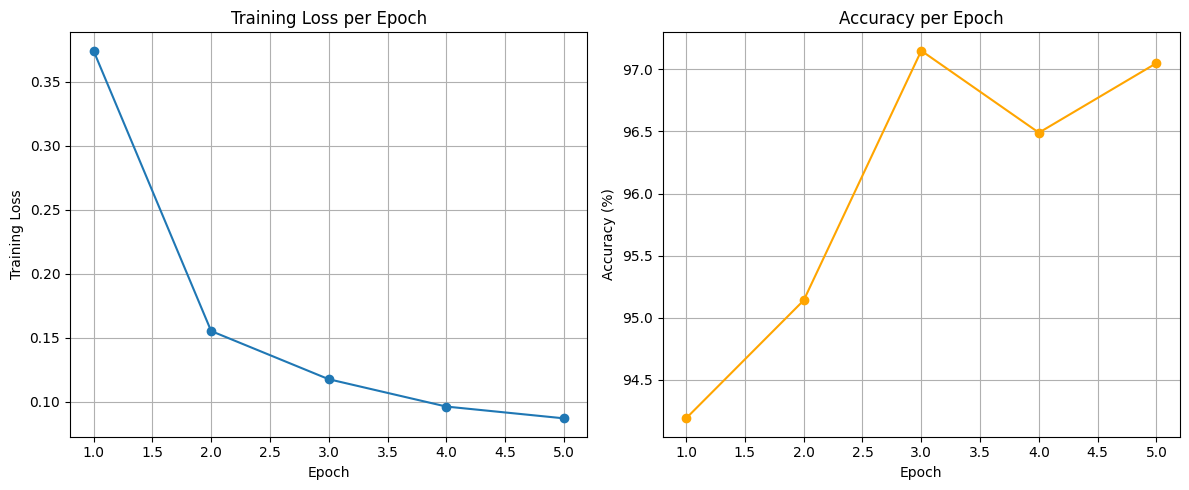

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()

        self.d_model = d_model  # Dimensionality of Model
        self.img_size = img_size  # Image Size
        self.patch_size = patch_size  # Patch Size
        self.n_channels = n_channels  # Number of Channels

        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2)  # (B, d_model, P_col, P_row) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, d_model, P) -> (B, P, d_model)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe

        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

        self.softmax = nn.Softmax(dim=-1)

    def gaussian_kernel(self, attention_scores):
        attention_scores = attention_scores - attention_scores.mean(dim=-1, keepdim=True)
        gaussian_weights = torch.exp(-attention_scores**2)
        gaussian_weights = gaussian_weights / (gaussian_weights.sum(dim=-1, keepdim=True) + 1e-8)
        if torch.any(torch.isnan(gaussian_weights)):
            print("NaN detected in Gaussian weights!")

        return gaussian_weights


    def forward(self, x):
        Q = self.query(x)  # Queries
        K = self.key(x)    # Keys
        V = self.value(x)  # Values

        # Scaled Dot-Product Attention
        attention_scores = Q @ K.transpose(-2, -1)
        attention_scores = attention_scores / (self.head_size ** 0.5)

        # Apply Gaussian Attention
        gaussian_attention = self.gaussian_kernel(attention_scores)

        # Weighted sum of values
        output = gaussian_attention @ V
        return output

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Concatenate outputs from each head
        attention_outputs = [head(x) for head in self.heads]
        x = torch.cat(attention_outputs, dim=-1)
        return self.linear(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.n_channels = n_channels  # Number of channels
        self.n_heads = n_heads  # Number of attention heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP
        self.classifier = nn.Linear(self.d_model, self.n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # Use the class token for classification
        return x

# Hyperparameters
d_model = 128  # Increased for better representation
n_classes = 10
img_size = (32, 32)
patch_size = (16, 16)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 5
alpha = 0.001

# Data Transformations
transform = T.Compose([
    T.Resize(img_size),
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))  # Normalize to mean=0.5, std=0.5
])


# Load MNIST Dataset
train_set = MNIST(
    root="./../datasets", train=True, download=True, transform=transform
)
test_set = MNIST(
    root="./../datasets", train=False, download=True, transform=transform
)

train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

# Initialize Model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Optimizer and Loss Function
optimizer = Adam(transformer.parameters(), lr=alpha)
criterion = nn.CrossEntropyLoss()

# Training Loop
epoch_losses = []
accuracy = [] # Initialize accuracy list outside the loop
for epoch in range(epochs):
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        torch.nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1.0)
        optimizer.zero_grad()

        outputs = transformer(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()
    epoch_losses.append(training_loss / len(train_loader)) # Store epoch loss
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}')

    # Evaluation after each epoch
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = transformer(images)

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_accuracy = 100 * correct / total  # Calculate accuracy for current epoch
    accuracy.append(epoch_accuracy)  # Append to accuracy list
    print(f'\nModel Accuracy: {100 * correct / total:.2f} %')

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), epoch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss per Epoch")
plt.grid(True)


# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), accuracy, marker='o', color='orange')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy per Epoch")
plt.grid(True)

plt.tight_layout()
plt.show()

# **Vision Transformer with CIFAR-10 Dataset**

After successfully completing  and understanding the basics I Decided to take next step which is implementing CIFAR-10 dataset to the same model this dataset is huge comapire to MNIST so it require complex vision transformer so I tried. finally after completion i didn't got the expected results but I think if we do fine tunning and setting hyperparameter correctly we can improve the accuracy.

In [3]:
!pip install timm

import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from torch.utils.data import DataLoader
from timm import create_model  # Pretrained ViT from timm library

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Augmentation and Preprocessing
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 Dataset
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Load Pretrained ViT Model
model = create_model(
    'vit_base_patch16_384',  # Use a ViT model with a larger input size
    pretrained=True,
    num_classes=10,
    img_size=32
).to(device)

# Resize CIFAR-10 images before passing into the ViT
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.AutoAugment(T.AutoAugmentPolicy.CIFAR10),
    T.Resize(384),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])
# Re-create the dataloaders with resized images
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)

# Loss Function with Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Training Loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    scheduler.step()
    print(f'Epoch {epoch + 1}/{epochs} loss: {running_loss / len(train_loader):.3f}')

# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'\nModel Accuracy: {accuracy:.2f}%')


Files already downloaded and verified
Files already downloaded and verified


model.safetensors:   0%|          | 0.00/347M [00:00<?, ?B/s]

Epoch 1/100 loss: 2.002
Epoch 2/100 loss: 1.566
Epoch 3/100 loss: 1.475
Epoch 4/100 loss: 1.420
Epoch 5/100 loss: 1.398
Epoch 6/100 loss: 1.367
Epoch 7/100 loss: 1.341
Epoch 8/100 loss: 1.320
Epoch 9/100 loss: 1.302
Epoch 10/100 loss: 1.286
Epoch 11/100 loss: 1.275
Epoch 12/100 loss: 1.257
Epoch 13/100 loss: 1.247
Epoch 14/100 loss: 1.233
Epoch 15/100 loss: 1.221
Epoch 16/100 loss: 1.214
Epoch 17/100 loss: 1.203
Epoch 18/100 loss: 1.186
Epoch 19/100 loss: 1.177
Epoch 20/100 loss: 1.166
Epoch 21/100 loss: 1.159
Epoch 22/100 loss: 1.144
Epoch 23/100 loss: 1.140
Epoch 24/100 loss: 1.122
Epoch 25/100 loss: 1.116
Epoch 26/100 loss: 1.106
Epoch 27/100 loss: 1.094
Epoch 28/100 loss: 1.083
Epoch 29/100 loss: 1.076
Epoch 30/100 loss: 1.067
Epoch 31/100 loss: 1.056
Epoch 32/100 loss: 1.047
Epoch 33/100 loss: 1.041
Epoch 34/100 loss: 1.030
Epoch 35/100 loss: 1.020
Epoch 36/100 loss: 1.011
Epoch 37/100 loss: 1.000
Epoch 38/100 loss: 0.993
Epoch 39/100 loss: 0.986
Epoch 40/100 loss: 0.972
Epoch 41/

# **Improved version of vit with cifar-10**


In [ ]:
import torch
import torch.nn as nn
from torch.optim import AdamW
from torchvision.datasets import CIFAR10
from torchvision import transforms as T
from torch.utils.data import DataLoader
from timm import create_model
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformations
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.Resize(128),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Resize(128),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 Dataset
train_set = CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=1)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=1)
# Load Pretrained ViT Model
model = create_model(
    'vit_base_patch16_384',
    pretrained=True,
    num_classes=10,
    img_size=128
).to(device)

# Loss Function with Label Smoothing
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# Optimizer and Scheduler
optimizer = AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100)

# Function to calculate metrics
def calculate_metrics(preds, labels):
    preds = preds.cpu().numpy()
    labels = labels.cpu().numpy()
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    accuracy = accuracy_score(labels, preds)
    return precision, recall, f1, accuracy

# Training Loop
epochs = 100
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.detach().cpu())
        all_labels.extend(labels.detach().cpu())

    train_precision, train_recall, train_f1, train_accuracy = calculate_metrics(torch.stack(all_preds), torch.stack(all_labels))
    print(f'Epoch {epoch + 1}/{epochs} - Loss: {running_loss / len(train_loader):.3f}, Precision: {train_precision:.3f}, Recall: {train_recall:.3f}, F1: {train_f1:.3f}, Accuracy: {train_accuracy:.3f}')

    scheduler.step()

# Evaluation
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.detach().cpu())
        all_labels.extend(labels.detach().cpu())

test_precision, test_recall, test_f1, test_accuracy = calculate_metrics(torch.stack(all_preds), torch.stack(all_labels))
print(f'\nTest - Precision: {test_precision:.3f}, Recall: {u :.3f}, F1: {test_f1:.3f}, Accuracy: {test_accuracy:.3f}')


## **Tried to generate my own attention**

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()

        self.d_model = d_model  # Dimensionality of Model
        self.img_size = img_size  # Image Size
        self.patch_size = patch_size  # Patch Size
        self.n_channels = n_channels  # Number of Channels

        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)  # (B, C, H, W) -> (B, d_model, P_col, P_row)
        x = x.flatten(2)  # (B, d_model, P_col, P_row) -> (B, d_model, P)
        x = x.transpose(1, 2)  # (B, d_model, P) -> (B, P, d_model)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()

        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))  # Classification Token

        # Creating positional encoding
        pe = torch.zeros(max_seq_length, d_model)

        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        # Expand to have class token for every image in batch
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)

        # Adding class tokens to the beginning of each embedding
        x = torch.cat((tokens_batch, x), dim=1)

        # Add positional encoding to embeddings
        x = x + self.pe

        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size

        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        # Obtaining Queries, Keys, and Values
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Dot Product of Queries and Keys
        attention = Q @ K.transpose(-2, -1)

        # Scaling
        attention = attention / (self.head_size ** 0.5)

        attention = torch.softmax(attention, dim=-1)

        attention = attention @ V

        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        # Concatenate outputs from each head
        attention_outputs = [head(x) for head in self.heads]
        x = torch.cat(attention_outputs, dim=-1)
        return self.linear(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads

        # Sub-Layer 1 Normalization
        self.ln1 = nn.LayerNorm(d_model)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(d_model, n_heads)

        # Sub-Layer 2 Normalization
        self.ln2 = nn.LayerNorm(d_model)

        # Multilayer Perception
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        # Residual Connection After Sub-Layer 1
        out = x + self.mha(self.ln1(x))

        # Residual Connection After Sub-Layer 2
        out = out + self.mlp(self.ln2(out))

        return out
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()

        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "img_size dimensions must be divisible by patch_size dimensions"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"

        self.d_model = d_model  # Dimensionality of model
        self.n_classes = n_classes  # Number of classes
        self.img_size = img_size  # Image size
        self.patch_size = patch_size  # Patch size
        self.n_channels = n_channels  # Number of channels
        self.n_heads = n_heads  # Number of attention heads

        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1

        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])

        # Classification MLP
        self.classifier = nn.Linear(self.d_model, self.n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])  # Use the class token for classification
        return x

# Hyperparameters
d_model = 168  # Increased for better representation
n_classes = 10
img_size = (32, 32)
patch_size = (32, 32)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 10
alpha = 0.005

# Data Transformations
transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),  # Convert images to PyTorch tensors
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))   # Normalize the images
])

# Load CIFAR-10 training data
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Load CIFAR-10 test data
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = VisionTransformer(d_model=128, n_classes=10, img_size=(32, 32), patch_size=(16, 16), n_channels=3, n_heads=4, n_layers=3)
model.to(device)


# Initialize Model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs =  model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}')

# Evaluation
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'\nModel Accuracy: {100 * correct / total:.2f} %')

Files already downloaded and verified
Files already downloaded and verified
Using device:  cuda (Tesla T4)
Epoch 1/10 loss: 1.857
Epoch 2/10 loss: 1.652
Epoch 3/10 loss: 1.566
Epoch 4/10 loss: 1.511
Epoch 5/10 loss: 1.463
Epoch 6/10 loss: 1.416
Epoch 7/10 loss: 1.385
Epoch 8/10 loss: 1.346
Epoch 9/10 loss: 1.314
Epoch 10/10 loss: 1.289

Model Accuracy: 52.18 %


Attempt 2 with slightly changes and improved

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torchvision.datasets.mnist import MNIST
from torch.utils.data import DataLoader
import numpy as np
import torch.optim as optim

class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.d_model = d_model
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.linear_project = nn.Conv2d(self.n_channels, self.d_model, kernel_size=self.patch_size, stride=self.patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                if i % 2 == 0:
                    pe[pos][i] = np.sin(pos / (10000 ** (i / d_model)))
                else:
                    pe[pos][i] = np.cos(pos / (10000 ** ((i - 1) / d_model)))
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size()[0], -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        x = x + self.pe
        return x

class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.head_size = head_size
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        attention = Q @ K.transpose(-2, -1)
        attention = attention / (self.head_size ** 0.5)
        attention = torch.softmax(attention, dim=-1)
        attention = attention @ V
        return attention

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        attention_outputs = [head(x) for head in self.heads]
        x = torch.cat(attention_outputs, dim=-1)
        return self.linear(x)

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        out = x + self.mha(self.ln1(x))
        out = out + self.mlp(self.ln2(out))
        return out

class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0,
        assert d_model % n_heads == 0,
        self.d_model = d_model
        self.n_classes = n_classes
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_channels = n_channels
        self.n_heads = n_heads
        self.n_patches = (self.img_size[0] * self.img_size[1]) // (self.patch_size[0] * self.patch_size[1])
        self.max_seq_length = self.n_patches + 1
        self.patch_embedding = PatchEmbedding(self.d_model, self.img_size, self.patch_size, self.n_channels)
        self.positional_encoding = PositionalEncoding(self.d_model, self.max_seq_length)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(self.d_model, self.n_heads) for _ in range(n_layers)])
        self.classifier = nn.Linear(self.d_model, self.n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x

# Hyperparameters
d_model = 228
n_classes = 10
img_size = (32, 32)
patch_size = (32, 32)
n_channels = 1
n_heads = 4
n_layers = 3
batch_size = 128
epochs = 10
alpha = 0.005

# Data Transformations
transform = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 training data
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")

model = VisionTransformer(d_model=128, n_classes=10, img_size=(32, 32), patch_size=(16, 16), n_channels=3, n_heads=4, n_layers=3)
model.to(device)

# Initialize Model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)

# Optimizer and Loss Function
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    training_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
    print(f'Epoch {epoch + 1}/{epochs} loss: {training_loss / len(train_loader):.3f}')

# Evaluation
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    print(f'\nModel Accuracy: {100 * correct / total:.2f} %')


Files already downloaded and verified
Files already downloaded and verified
Using device:  cuda (Tesla T4)
Epoch 1/10 loss: 1.848
Epoch 2/10 loss: 1.647
Epoch 3/10 loss: 1.565
Epoch 4/10 loss: 1.509
Epoch 5/10 loss: 1.464
Epoch 6/10 loss: 1.418
Epoch 7/10 loss: 1.381
Epoch 8/10 loss: 1.340
Epoch 9/10 loss: 1.315
Epoch 10/10 loss: 1.286

Model Accuracy: 53.53 %


attempt 3

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torch.utils.data import DataLoader
import numpy as np

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.linear_project = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2).transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        pe = torch.zeros(max_seq_length, d_model)
        for pos in range(max_seq_length):
            for i in range(d_model):
                pe[pos][i] = np.sin(pos / (10000 ** (i / d_model))) if i % 2 == 0 else np.cos(pos / (10000 ** (i / d_model)))
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        return x + self.pe

# Attention Mechanisms
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q, K, V = self.query(x), self.key(x), self.value(x)
        attention = (Q @ K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        return torch.softmax(attention, dim=-1) @ V

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        self.linear = nn.Linear(d_model, d_model)

    def forward(self, x):
        return self.linear(torch.cat([head(x) for head in self.heads], dim=-1))

class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        return x + self.mlp(self.ln2(x + self.mha(self.ln1(x))))

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "Invalid patch size"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        self.positional_encoding = PositionalEncoding(d_model, (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1]) + 1)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoder(d_model, n_heads) for _ in range(n_layers)])
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        x = self.transformer_encoder(x)
        return self.classifier(x[:, 0])

# Hyperparameters
d_model = 256
n_classes = 10
img_size = (32, 32)
patch_size = (8, 8)
n_channels = 3
n_heads = 8
n_layers = 4
batch_size = 128
epochs = 20
learning_rate = 0.001

# Data Transformations and Loaders
transform = T.Compose([T.ToTensor(), T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_set, shuffle=False, batch_size=batch_size)

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Initialize Model
transformer = VisionTransformer(d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers).to(device)
optimizer = Adam(transformer.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Training Loop
for epoch in range(epochs):
    transformer.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = transformer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {train_loss / len(train_loader):.4f}")

# Evaluation
transformer.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = transformer(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"Test Accuracy: {100 * correct / total:.2f}%")


100%|██████████| 170M/170M [00:11<00:00, 14.6MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Using device: cpu
Epoch [1/20], Loss: 1.7514
Epoch [2/20], Loss: 1.5132
Epoch [3/20], Loss: 1.4384
Epoch [4/20], Loss: 1.3888
Epoch [5/20], Loss: 1.3591
Epoch [6/20], Loss: 1.3230
Epoch [7/20], Loss: 1.3292
Epoch [8/20], Loss: 1.3248
Epoch [9/20], Loss: 1.3056
Epoch [10/20], Loss: 1.2611


attempt 4
this model should not be consider as it was my first tried and will try to improved the results  

In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms as T
from torch.optim import Adam
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Patch Embedding Layer
class PatchEmbedding(nn.Module):
    def __init__(self, d_model, img_size, patch_size, n_channels):
        super().__init__()
        self.linear_project = nn.Conv2d(n_channels, d_model, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.linear_project(x)
        x = x.flatten(2).transpose(1, 2)
        return x

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super().__init__()
        self.cls_token = nn.Parameter(torch.randn(1, 1, d_model))
        pe = torch.zeros(max_seq_length, d_model)

        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        tokens_batch = self.cls_token.expand(x.size(0), -1, -1)
        x = torch.cat((tokens_batch, x), dim=1)
        return x + self.pe

# Attention Head
class AttentionHead(nn.Module):
    def __init__(self, d_model, head_size):
        super().__init__()
        self.query = nn.Linear(d_model, head_size)
        self.key = nn.Linear(d_model, head_size)
        self.value = nn.Linear(d_model, head_size)

    def forward(self, x):
        Q, K, V = self.query(x), self.key(x), self.value(x)
        attention = (Q @ K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attention_weights = torch.softmax(attention, dim=-1)
        return attention_weights @ V, attention_weights

# Multi-Head Attention
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        self.heads = nn.ModuleList([AttentionHead(d_model, d_model // n_heads) for _ in range(n_heads)])
        # The output dimension of the linear layer should be d_model
        self.linear = nn.Linear(d_model, d_model) # Change is here

    def forward(self, x):
        heads_output, attentions = zip(*[head(x) for head in self.heads])
        # Concatenate the heads' output along the head_size dimension
        concat_output = torch.cat(heads_output, dim=-1) # Change is here
        output = self.linear(concat_output)
        average_attention = torch.stack(attentions).mean(0)
        return output, average_attention
# Transformer Encoder
class TransformerEncoder(nn.Module):
    def __init__(self, d_model, n_heads, r_mlp=4):
        super().__init__()
        self.ln1 = nn.LayerNorm(d_model)
        self.mha = MultiHeadAttention(d_model, n_heads)
        self.ln2 = nn.LayerNorm(d_model)
        self.mlp = nn.Sequential(
            nn.Linear(d_model, d_model * r_mlp),
            nn.GELU(),
            nn.Linear(d_model * r_mlp, d_model)
        )

    def forward(self, x):
        x, attention = self.mha(self.ln1(x))
        x = x + self.mlp(self.ln2(x))
        return x, attention

# Vision Transformer
class VisionTransformer(nn.Module):
    def __init__(self, d_model, n_classes, img_size, patch_size, n_channels, n_heads, n_layers):
        super().__init__()
        assert img_size[0] % patch_size[0] == 0 and img_size[1] % patch_size[1] == 0, "Invalid patch size"
        assert d_model % n_heads == 0, "d_model must be divisible by n_heads"
        self.patch_embedding = PatchEmbedding(d_model, img_size, patch_size, n_channels)
        self.positional_encoding = PositionalEncoding(d_model, (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1]) + 1)
        self.transformer_encoder = nn.ModuleList([TransformerEncoder(d_model, n_heads, r_mlp=4) for _ in range(n_layers)])
        self.classifier = nn.Linear(d_model, n_classes)

    def forward(self, images):
        x = self.patch_embedding(images)
        x = self.positional_encoding(x)
        attentions = []
        for encoder in self.transformer_encoder:
            x, attn = encoder(x)
            attentions.append(attn)
        x = self.classifier(x[:, 0])
        return x, torch.stack(attentions).mean(0)  # Return average of attentions across layers for visualization

# Data Transformations and Loaders
transform_train = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.RandomRotation(15),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
train_loader = DataLoader(train_set, shuffle=True, batch_size=128)
test_loader = DataLoader(test_set, shuffle=False, batch_size=128)

# Device Setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transformer = VisionTransformer(d_model=256, n_classes=10, img_size=(32, 32), patch_size=(8, 8), n_channels=3, n_heads=8, n_layers=4).to(device)
optimizer = Adam(transformer.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Training with Learning Rate Scheduler
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

for epoch in range(20):
    transformer.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = transformer(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    scheduler.step()
    print(f"Epoch [{epoch + 1}/20], Loss: {train_loss / len(train_loader):.4f}")

# Evaluation
transformer.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs, attentions = transformer(images)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"Test Metrics:\n Accuracy: {accuracy:.2f}\n Precision: {precision:.2f}\n Recall: {recall:.2f}\n F1-Score: {f1:.2f}")

# Visualization of metrics
metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'red', 'purple'])
plt.xlabel('Metric')
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.ylim([0, 1])
plt.show()


## Basline model without attention mechnism

Files already downloaded and verified
Files already downloaded and verified
Epoch 1, Batch 2000: Loss: 2.21
Epoch 1, Batch 4000: Loss: 1.91
Epoch 1, Batch 6000: Loss: 1.69
Epoch 1, Batch 8000: Loss: 1.58
Epoch 1, Batch 10000: Loss: 1.50
Epoch 1, Batch 12000: Loss: 1.43
Epoch 2, Batch 2000: Loss: 1.37
Epoch 2, Batch 4000: Loss: 1.31
Epoch 2, Batch 6000: Loss: 1.32
Epoch 2, Batch 8000: Loss: 1.27
Epoch 2, Batch 10000: Loss: 1.26
Epoch 2, Batch 12000: Loss: 1.25
Epoch 3, Batch 2000: Loss: 1.18
Epoch 3, Batch 4000: Loss: 1.17
Epoch 3, Batch 6000: Loss: 1.16
Epoch 3, Batch 8000: Loss: 1.17
Epoch 3, Batch 10000: Loss: 1.16
Epoch 3, Batch 12000: Loss: 1.14
Epoch 4, Batch 2000: Loss: 1.07
Epoch 4, Batch 4000: Loss: 1.06
Epoch 4, Batch 6000: Loss: 1.08
Epoch 4, Batch 8000: Loss: 1.07
Epoch 4, Batch 10000: Loss: 1.08
Epoch 4, Batch 12000: Loss: 1.07
Epoch 5, Batch 2000: Loss: 0.98
Epoch 5, Batch 4000: Loss: 0.99
Epoch 5, Batch 6000: Loss: 1.01
Epoch 5, Batch 8000: Loss: 1.00
Epoch 5, Batch 10000

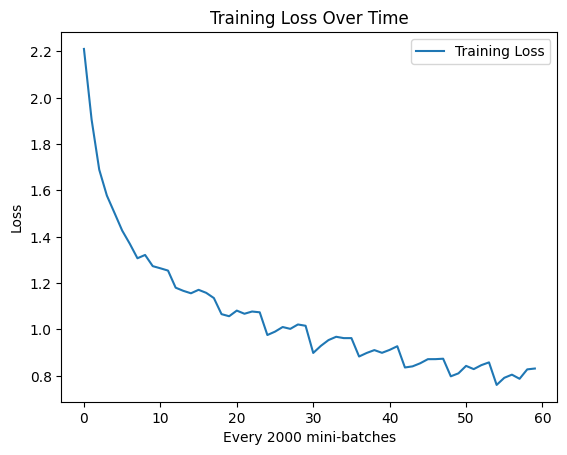

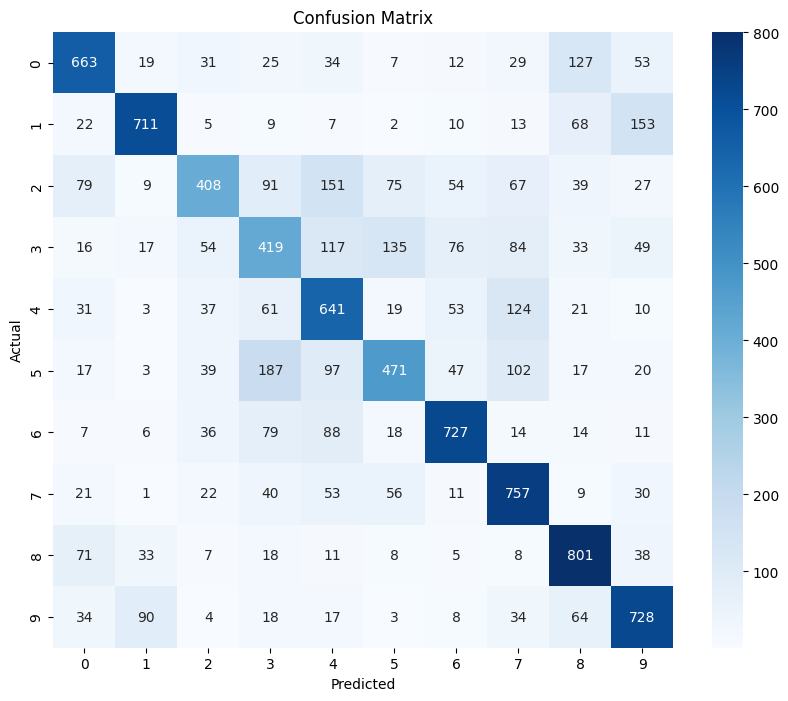

              precision    recall  f1-score   support

           0       0.69      0.66      0.68      1000
           1       0.80      0.71      0.75      1000
           2       0.63      0.41      0.50      1000
           3       0.44      0.42      0.43      1000
           4       0.53      0.64      0.58      1000
           5       0.59      0.47      0.53      1000
           6       0.72      0.73      0.73      1000
           7       0.61      0.76      0.68      1000
           8       0.67      0.80      0.73      1000
           9       0.65      0.73      0.69      1000

    accuracy                           0.63     10000
   macro avg       0.63      0.63      0.63     10000
weighted avg       0.63      0.63      0.63     10000



In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# Transformations applied on each image
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Loading the CIFAR-10 datasets
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = DataLoader(testset, batch_size=4, shuffle=False)

# Defining the CNN architecture
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = BasicCNN()

# Define a Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Initialize lists to track loss
epoch_losses = []

# Train the network
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:  # print every 2000 mini-batches
            avg_loss = running_loss / 2000
            print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss: {avg_loss:.2f}')
            epoch_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training')

# Plot training loss
plt.plot(epoch_losses, label='Training Loss')
plt.xlabel('Every 2000 mini-batches')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

# Evaluate the network on the test dataset
def evaluate_model(model, loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data in loader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.numpy())
            all_labels.extend(labels.numpy())

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(all_labels, all_preds))

evaluate_model(net, testloader)

# Save the trained model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)


First dataset plot was not properly plotted so here is corrected verson

In [2]:
import torchvision.datasets as datasets
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())

from collections import Counter
train_class_counts = Counter([label for _, label in trainset])
test_class_counts = Counter([label for _, label in testset])

print("Training class distribution:", train_class_counts)
print("Testing class distribution:", test_class_counts)


100%|██████████| 170M/170M [00:04<00:00, 34.8MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Training class distribution: Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
Testing class distribution: Counter({3: 1000, 8: 1000, 0: 1000, 6: 1000, 1: 1000, 9: 1000, 5: 1000, 7: 1000, 4: 1000, 2: 1000})


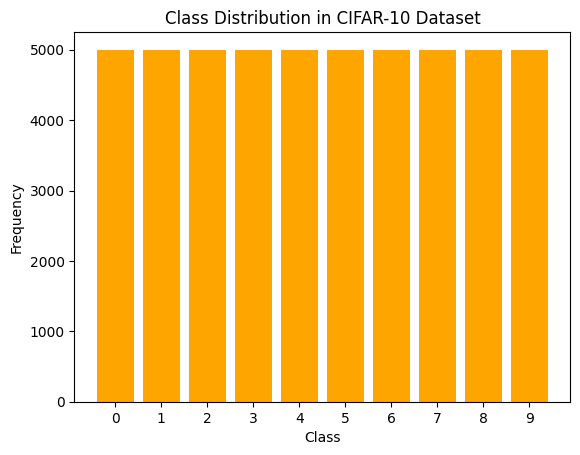

In [5]:
import matplotlib.pyplot as plt

# Assuming 'train_class_counts' is a dictionary with class labels as keys and counts as values
classes = list(range(10))  # CIFAR-10 classes labeled 0 through 9
frequencies = [train_class_counts[i] for i in classes]  # Gather frequencies in order of the classes

plt.bar(classes, frequencies, color='orange')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Class Distribution in CIFAR-10 Dataset')
plt.xticks(classes)
plt.show()
